# Food trucks

**Inspired by:** Baker, C. L., Jara-Ettinger, J., Saxe, R., & Tenenbaum, J. B. (2017). _Rational quantitative attribution of beliefs, desires and percepts in human mentalizing._ Nature Human Behaviour, 1(4), 0064.

A hungry grad student heads out to get food from a food truck. The nearby parking spot, which is visible, has a Korean food truck. The further parking spot, which is hidden behind a wall, may have either a Lebanese or Mexican food truck. Today it has a Lebanese food truck. The grad student goes around the wall, then turns around and comes back to the Korean food truck. What can we deduce is the grad student's favorite cuisine?

## Imports

In [1]:
import jax
import jax.numpy as np
from memo import memo, domain
from enum import IntEnum
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import interact

## State space

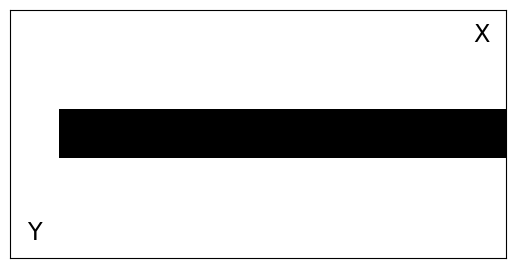

In [2]:
W, H = 10, 5
maze = np.zeros((W, H))
maze = maze.at[1:, 2].set(1)
maze = maze.reshape(-1)

S = domain(x=W, y=H)
SPOT_X_LOC = S(W - 1, 0)
SPOT_Y_LOC = S(0, H - 1)

@jax.jit
def is_terminating(s):
    return (s == SPOT_X_LOC) | (s == SPOT_Y_LOC)

plt.imshow(1 - maze.reshape((W, H)).T, cmap='gray')
plt.text(S.x(SPOT_X_LOC), S.y(SPOT_X_LOC), 'X', ha='center', va='center', size='xx-large')
plt.text(S.x(SPOT_Y_LOC), S.y(SPOT_Y_LOC), 'Y', ha='center', va='center', size='xx-large')
plt.xticks([])
plt.yticks([]);

## Action space

In [3]:
class A(IntEnum):
    LEFT = 0
    RIGHT = 1
    UP = 2
    DOWN = 3
    NOP = 4

coord_actions = np.array([[-1, 0], [+1, 0], [0, -1], [0, +1], [0, 0]])

@jax.jit
def Tr(s, a, s_):
    x, y = S._tuple(s)
    next_coords = np.array([x, y]) + coord_actions[a]
    next_state = S(
        np.clip(next_coords[0], 0, W - 1),
        np.clip(next_coords[1], 0, H - 1)
    )
    return (
        + 1.0 * ((maze[next_state] == 0) & (next_state == s_))  # next state free, can move there
        + 1.0 * ((maze[next_state] == 1) & (s == s_)) # next state occupied, stay where you are
    )

## Rewards

In [4]:
Utility = np.array([-20, 0, 50, 100])
G = domain(uK=len(Utility), uL=len(Utility), uM=len(Utility))

class D(IntEnum):
    L_PARKED = 0
    M_PARKED = 1

@jax.jit
def R(d, s, g):
    uK, uL, uM = G._tuple(g)
    return np.select([
        s == SPOT_Y_LOC,
        (s == SPOT_X_LOC) & (d == D.L_PARKED),
        (s == SPOT_X_LOC) & (d == D.M_PARKED)
    ], [ Utility[uK], Utility[uL], Utility[uM] ], default=0)

@jax.jit
def cost(a):
    return 1 * (a != A.NOP)

gamma = 0.99
beta = 2.5

## Warm-up: MDP Value Iteration

In [5]:
@memo(cache=True)
def Q_mdp[d: D, s: S, a: A, g: G](t):
    alice: knows(d, s, a, g)
    alice: given(s_ in S, wpp=Tr(s, a, s_))
    alice: chooses(a_ in A, to_maximize=Q_mdp[d, s_, a_, g](t - 1) if t > 0 else 1)
    return E[ alice[
        R(d, s_, g) - cost(a) + (
            0 if t <= 0 else 0 if is_terminating(s_) else
            {gamma} * Q_mdp[d, s_, a_, g](t - 1)
        )
    ] ]
%time q_mdp = Q_mdp(100)
q_mdp.shape

CPU times: user 1.28 s, sys: 218 ms, total: 1.5 s
Wall time: 815 ms


(2, 50, 5, 64)

In [6]:
v_mdp = q_mdp.max(axis=2)

@interact(d=D, uK=range(len(Utility)), uL=range(len(Utility)), uM=range(len(Utility)))
def mdp_viz(d, uK=20, uL=0, uM=20):
    v = v_mdp[d, :, G(uK, uL, uM)]
    plt.colorbar(plt.imshow(((1 - maze) * v).reshape((W, H)).T, cmap='gray', vmin=-20, vmax=100), location='bottom')
    plt.text(S.x(SPOT_X_LOC), S.y(SPOT_X_LOC), d.name[0], ha='center', va='center', size='xx-large', c='orange')
    plt.text(S.x(SPOT_Y_LOC), S.y(SPOT_Y_LOC), 'K', ha='center', va='center', size='xx-large', c='orange')
    plt.xticks([])
    plt.yticks([])

interactive(children=(Dropdown(description='d', options={'L_PARKED': <D.L_PARKED: 0>, 'M_PARKED': <D.M_PARKED:…

## Beliefs and observations

In [7]:
B = np.linspace(0, 1, 7)

@jax.jit
def get_belief(b, d):
    return np.array([b, 1 - b])[d]

class O(IntEnum):
    L_PARKED = 0
    M_PARKED = 1
    NOTHING = 2

def can_see_X(s):
    return S.y(s) < 2

@jax.jit
def obs(d, s, o):
    return np.select([
        can_see_X(s) & (d == D.L_PARKED),
        can_see_X(s) & (d == D.M_PARKED),
        ~can_see_X(s)
    ], [
        np.array([0.99, 0.0, 0.01])[o],
        np.array([0.0, 0.99, 0.01])[o],
        np.array([0.0, 0.0, 1.0])[o]
    ], default=0.0)

## Belief-space planning

In [8]:
@memo(cache=True)
def BeliefUpdate[b: B, s: S, o: O, b_: B]():
    alice: knows(b, s)
    alice: thinks[
        env: knows(b, s),
        env: chooses(d in D, wpp=get_belief(b, d)),
        env: chooses(o in O, wpp=obs(d, s, o))
    ]
    alice: observes [env.o] is o
    alice: knows(b_)
    return exp(-10 * alice[ abs(Pr[env.d == 0] - get_belief(b_, 0)) ])

@memo(cache=True)
def Q[b: B, s: S, a: A, g: G](t):
    alice: knows(b, s, a, g)
    alice: thinks[
        env: knows(b, s, a),
        env: chooses(d in D, wpp=get_belief(b, d))
    ]
    alice: given(s_ in S, wpp=Tr(s, a, s_))
    alice: thinks[
        env: knows(s_),
        env: chooses(o in O, wpp=obs(d, s_, o))
    ]
    alice: snapshots_self_as(future_alice)
    return E[alice[
        E[R(env.d, s_, g) - cost(a)] + (0.0 if t <= 0 else 0.0 if is_terminating(s_) else imagine[
        future_alice: observes [env.o] is env.o,
        future_alice: chooses(b_ in B, wpp=BeliefUpdate[b, s_, env.o, b_]()),
        future_alice: chooses(a_ in A, to_maximize=Q[b, s_, a_, g](t - 1)),
        {gamma} * E[future_alice[Q[b, s_, a_, g](t - 1)]]
    ])]]
%time v = Q(100).max(axis=2)

# plt.colorbar(
#     plt.imshow((v[2, :, G(2, 0, 2)] * (1 - maze)).reshape((W, H)).T),
#     location='bottom',
# )
# plt.xticks([])
# plt.yticks([]);

CPU times: user 1.75 s, sys: 220 ms, total: 1.97 s
Wall time: 736 ms


## Inverse planning

In [9]:
d0 = D.L_PARKED

s0 = S(3, 3)
actions = [
    A.LEFT, A.LEFT, A.LEFT, A.UP, A.UP,
    A.RIGHT, A.RIGHT, A.RIGHT,
    A.LEFT, A.LEFT, A.LEFT,
    A.DOWN, A.DOWN, A.DOWN
]

# s0 = S(8, 3)
# actions = [A.LEFT, A.LEFT, A.LEFT, A.LEFT, A.DOWN, A.LEFT, A.LEFT, A.LEFT, A.LEFT]

@memo(cache=True)
def invplan[b: B, s: S, g: G](t):
    viewer: thinks[
        alice: given(
            b in B, g in G, s in S,
            wpp=(s == {s0}) if t <= 0 else invplan[b, s, g](t - 1)
        ),
        alice: chooses(a in A, wpp=exp({beta} * Q[b, s, a, g](100)))
    ]
    viewer: observes_that[ alice.a == {actions[t]} ]
    viewer: thinks[
        alice: given(s_ in S, wpp=Tr(s, a, s_)),
        alice: given(o in O, wpp=obs({d0}, s_, o)),
        alice: given(b_ in B, wpp=BeliefUpdate[b, s_, o, b_]())
    ]

    viewer: knows(b, s, g)
    return viewer[Pr[b == alice.b_, s == alice.s_, g == alice.g ]]

  0%|          | 0/14 [00:00<?, ?it/s]

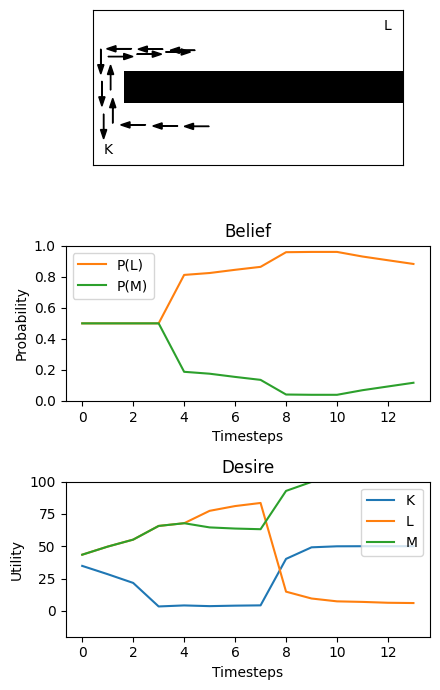

In [10]:
x, y = S._tuple(s0)

plt.figure(figsize=(4.5, 7))

plt.subplot(3, 1, 1)
plt.imshow(1 - maze.reshape((W, H)).T, cmap='gray')
plt.text(S.x(SPOT_X_LOC), S.y(SPOT_X_LOC), 'L', ha='center', va='center')
plt.text(S.x(SPOT_Y_LOC), S.y(SPOT_Y_LOC), 'K', ha='center', va='center')

GTS = np.array([[Utility[z] for z in G._tuple(g)] for g in G]).T
gs = []
bs = []
for i, a in enumerate(tqdm(actions)):
    drift = 0.25 * np.cos(np.pi * 2 * i / 20)
    ip = invplan(i)
    x_, y_ = S._tuple(np.nonzero(ip.sum(axis=(0, 2)))[0][0])
    plt.arrow(x + drift, y + drift, (x_ - x) * 0.8, (y_ - y) * 0.8, width=0.01, head_width=0.2, length_includes_head=True, fc='black')
    plt.xticks([])
    plt.yticks([])
    x, y = x_, y_
    gs.append((GTS * ip.sum(axis=(0, 1))).sum(axis=1))
    bs.append(np.sum(B * ip.sum(axis=(1, 2))))

plt.subplot(3, 1, 2)
plt.plot([])
plt.plot(bs, label='P(L)')
plt.plot(1 - np.array(bs), label='P(M)')
plt.xlabel('Timesteps')
plt.ylabel('Probability')
plt.legend()
plt.ylim(0, 1)
plt.title('Belief')

plt.subplot(3, 1, 3)
plt.plot(gs, label=['K', 'L', 'M'])
plt.xlabel('Timesteps')
plt.ylabel('Utility')
plt.ylim(np.min(Utility), np.max(Utility))
plt.title('Desire')
plt.legend()

plt.tight_layout()